In [1]:
# cd /bali/freqtrade

/bali/freqtrade


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import talib as ta
import talib.abstract as ta
import pandas_ta as pta
from technical import qtpylib


In [3]:
df = pd.read_json('/bali/freqtrade/user_data/data/binance/futures/ETH_USDT-1h-futures.json')
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
df['date'] = df.date.apply(lambda x: pd.to_datetime(x, unit='ms'))


In [4]:
# df1 = pd.read_json('2022-10-05 07:48:23.436271.json')                      
# df2 = pd.read_json('2022-10-05 10:33:39.353703.json')                      
# df1['long_profit'] = (df1['profit_ratio'].multiply(100)).round(2)
# df1['short_profit'] = (df2['profit_ratio'].multiply(100)).round(2)
# # df = df1[df.long_profit.notna()]
# # df[df.long_profit.notna()]
# df = df1.copy()
# # df = df[-10000:]
 
# df.loc[(df.long_profit > 0) & (df.short_profit < 0), 'label'] = 'long'
# df.loc[(df.long_profit < 0) & (df.short_profit > 0), 'label'] = 'short'
# df.loc[(~df['label'].isin(['long', 'short'])) & (df.long_profit.notna()), 'label'] = 'hold'
# """ prepare labels """
# df.loc[(df['trade'] == 1)& (df['macd'] > df['macdsignal']), 'position'] = 'bottom' 
# df.loc[(df['trade'] == 1)& (df['macd'] < df['macdsignal']), 'position'] = 'top'
# df.loc[(df['trade'] == 1)& (df['macd'] > df['macdsignal']), 'position'] = 'long' 
# df.loc[(df['trade'] == 1)& (df['macd'] < df['macdsignal']), 'position'] = 'short'

In [5]:
df['rsi'] = ta.RSI(df)
df['adx'] = ta.ADX(df)
df['volume_pct'] = df['volume'].pct_change()
df['close_pct'] = df['close'].pct_change()
df['close_log'] = np.log(df['close'])
macd = ta.MACD(df)
df['macd'] = macd['macd']
df['macdsignal'] = macd['macdsignal']
df['macdhist'] = macd['macdhist']
df['ao'] = qtpylib.awesome_oscillator(df)
df['uo'] = ta.ULTOSC(df)


features_kmeans_dict_20bar = {'adx':[], 'rsi':[], 'macdhist':[],'ao':[],'uo':[],'close_pct':[],'volume_pct':[] }
features_kmeans_dict_10bar = {'adx':[], 'rsi':[], 'macdhist':[],'ao':[],'uo':[],'close_pct':[],'volume_pct':[]}
features_kmeans_dict_3bar = {'adx':[], 'rsi':[], 'macdhist':[],'ao':[],'uo':[],'close_pct':[],'volume_pct':[]}
features_kmeans_dict_1bar = {'adx':[], 'rsi':[], 'macdhist':[],'ao':[],'uo':[],'close_pct':[],'volume_pct':[], 'close':[], 'volume':[], 'open':[], 'high':[], 'low':[]}

features_kemeans_dict = {'bar_20':features_kmeans_dict_20bar, 'bar_10':features_kmeans_dict_10bar, 'bar_3':features_kmeans_dict_3bar}

for i in features_kmeans_dict_20bar:
    for j in range(20,0,-1):
        features_kmeans_dict_20bar[i].append(f'{i}_-{j}')
        df[f'{i}_-{j}'] = df[f'{i}'].shift(j)
for i in features_kmeans_dict_10bar:
    for j in range(10,0,-1):
        features_kmeans_dict_10bar[i].append(f'{i}_-{j}')
        df[f'{i}_-{j}'] = df[f'{i}'].shift(j)
for i in features_kmeans_dict_3bar:
    for j in range(3,0,-1):
        features_kmeans_dict_3bar[i].append(f'{i}_-{j}')
        df[f'{i}_-{j}'] = df[f'{i}'].shift(j)
for i in features_kmeans_dict_1bar:
    for j in range(1,0,-1):
        features_kmeans_dict_1bar[i].append(f'{i}_-{j}')
        df[f'{i}_-{j}'] = df[f'{i}'].shift(j)


/tmp/ipykernel_80559/3272349391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{i}_-{j}'] = df[f'{i}'].shift(j)
/tmp/ipykernel_80559/3272349391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{i}_-{j}'] = df[f'{i}'].shift(j)
/tmp/ipykernel_80559/3272349391.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [6]:
# numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = df.apply(lambda x: np.log(x) if ((np.issubdtype(x.dtype, np.number)) and x.name not in ['close'] ) else x)
df.dtypes
# print(np.e)

# numeric_df = df.copy()
numeric_df


,date,open,high,low,close,volume,rsi,adx,volume_pct,close_pct,...,volume_pct_-5,volume_pct_-4,volume_pct_-3,volume_pct_-2,volume_pct_-1,close_-1,volume_-1,open_-1,high_-1,low_-1
0,2019-11-27 07:00:00,4.983607,4.983607,4.983607,146.00,-4.605170,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-11-27 08:00:00,4.828554,4.976803,4.828554,133.00,-2.525729,NaN,NaN,1.945910,NaN,...,NaN,NaN,NaN,NaN,NaN,4.983607,-4.605170,4.983607,4.983607,4.983607
2,2019-11-27 09:00:00,4.890349,4.890349,4.890349,133.00,-inf,NaN,NaN,NaN,-inf,...,NaN,NaN,NaN,NaN,1.945910,4.890349,-2.525729,4.828554,4.976803,4.828554
3,2019-11-27 10:00:00,4.957235,4.973418,4.956531,142.62,7.948989,NaN,NaN,inf,-2.626505,...,NaN,NaN,NaN,1.945910,NaN,4.890349,-inf,4.890349,4.890349,4.890349
4,2019-11-27 11:00:00,4.960745,4.989888,4.957375,146.58,9.113807,NaN,NaN,0.790882,-3.583940,...,NaN,NaN,1.945910,NaN,inf,4.960184,7.948989,4.957235,4.973418,4.956531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25438,2022-10-22 05:00:00,7.167586,7.167809,7.165493,1295.88,11.050885,3.961853,2.906427,-1.792782,NaN,...,-0.645104,-2.651801,-1.714569,NaN,NaN,7.167578,10.896881,7.168780,7.170027,7.167238
25439,2022-10-22 06:00:00,7.166953,7.168826,7.166667,1297.21,10.703167,3.987952,2.878522,NaN,-6.881766,...,-2.651801,-1.714569,NaN,NaN,-1.792782,7.166945,11.050885,7.167586,7.167809,7.165493
25440,2022-10-22 07:00:00,7.167979,7.170343,7.167979,1299.03,11.133591,4.022670,2.827438,-0.620064,-6.569135,...,-1.714569,NaN,NaN,-1.792782,NaN,7.167971,10.703167,7.166953,7.168826,7.166667
25441,2022-10-22 08:00:00,7.169381,7.171657,7.169365,1299.95,11.387087,4.039935,2.755338,-1.242985,-7.252755,...,NaN,NaN,-1.792782,NaN,-0.620064,7.169373,11.133591,7.167979,7.170343,7.167979


/tmp/ipykernel_80559/3392854626.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts.replace(np.inf, 0, inplace=True)
/tmp/ipykernel_80559/3392854626.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts.replace(-np.inf, 0, inplace=True)
/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = k

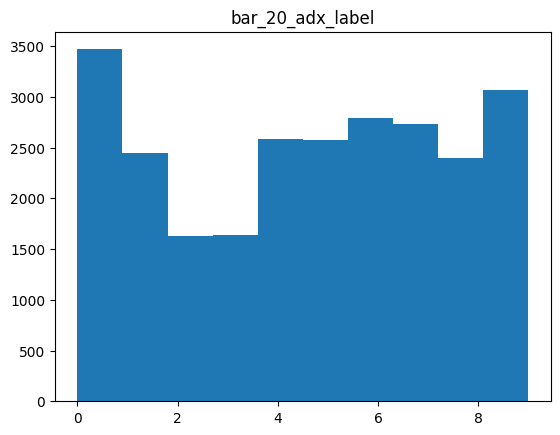

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


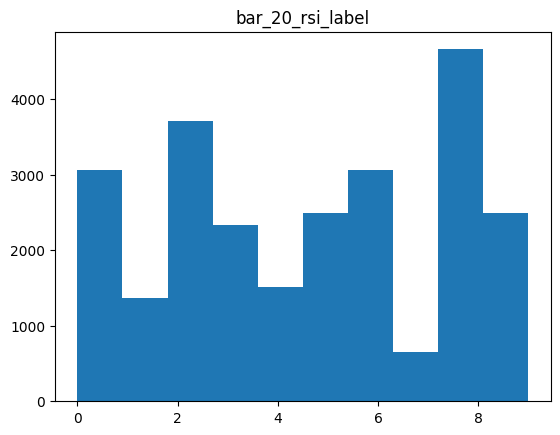

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


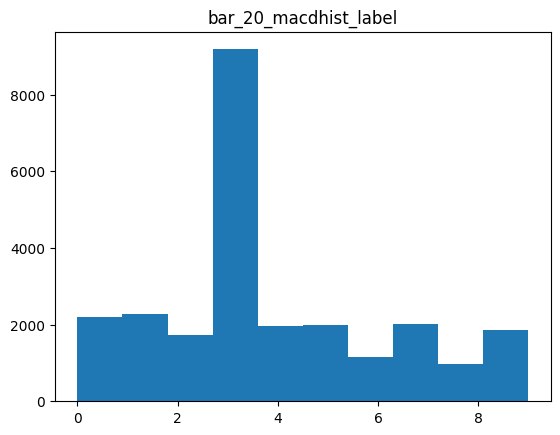

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


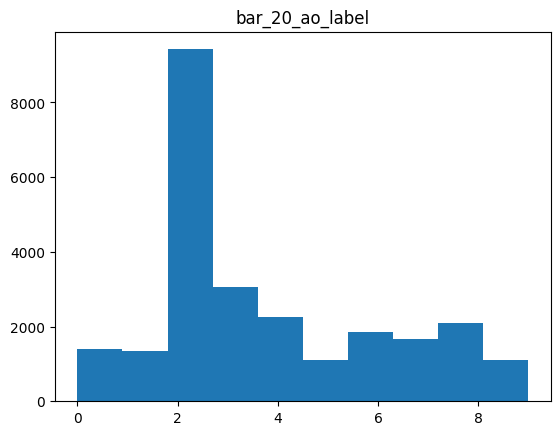

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


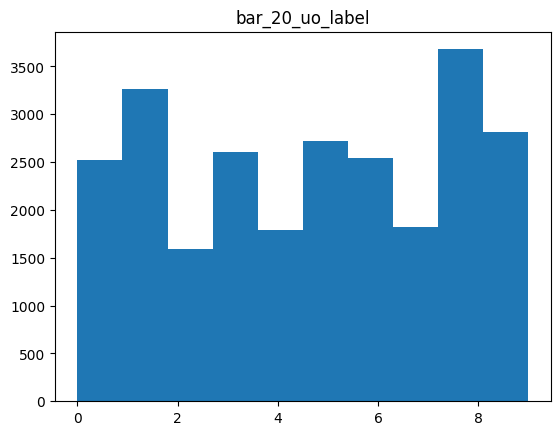

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


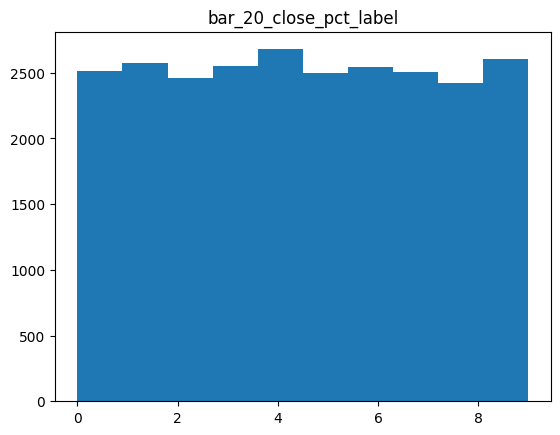

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


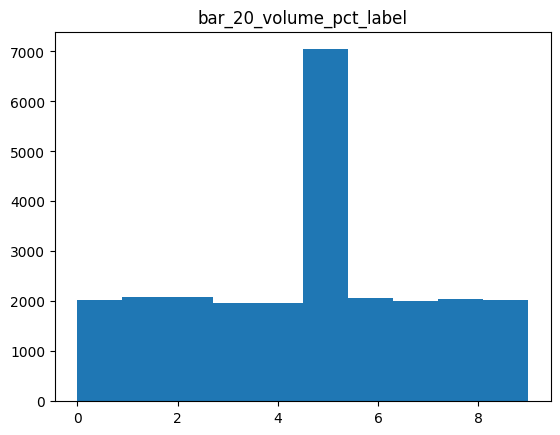

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


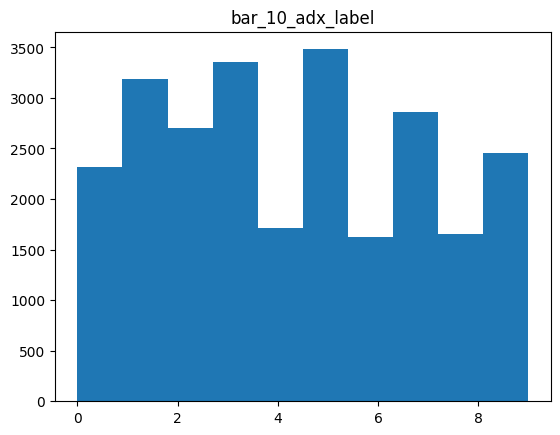

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


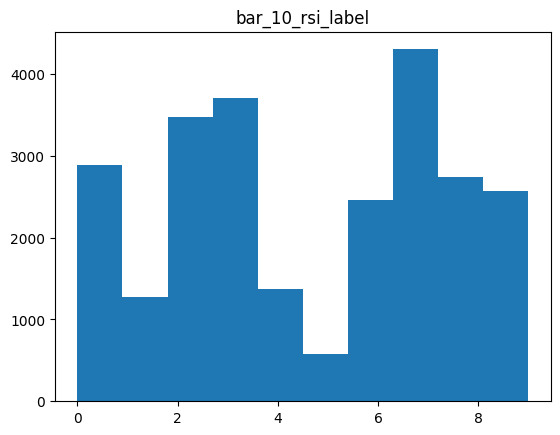

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


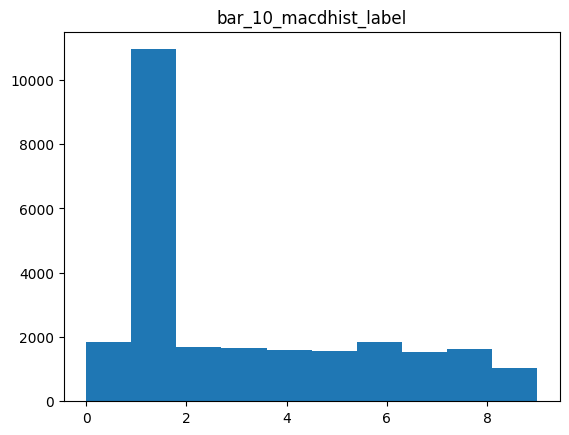

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


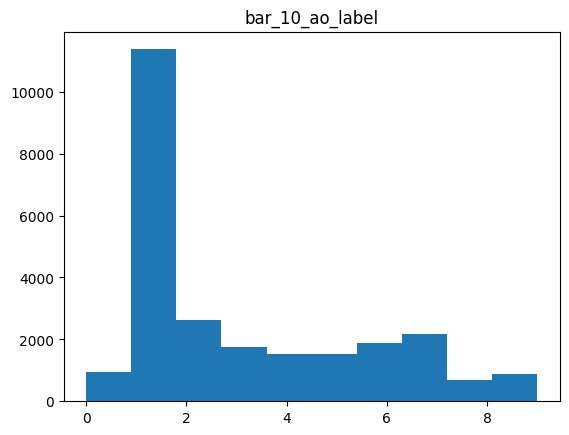

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


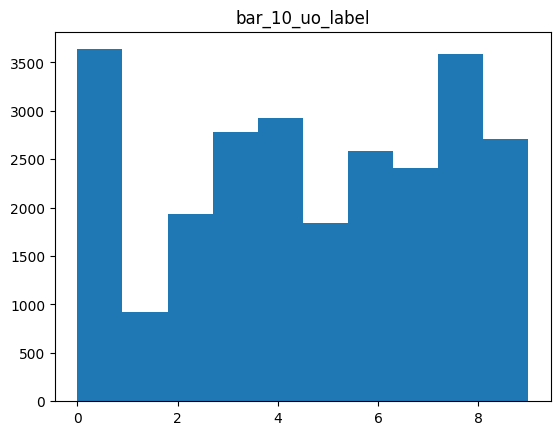

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


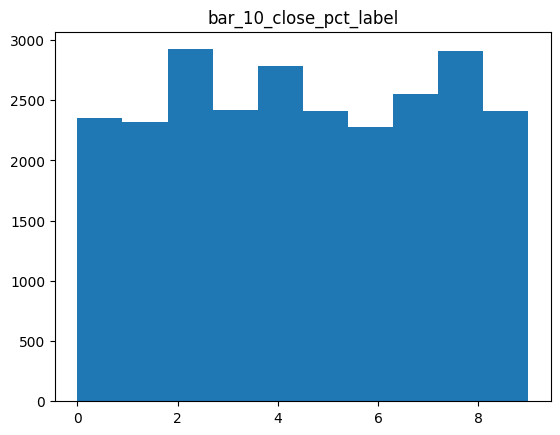

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


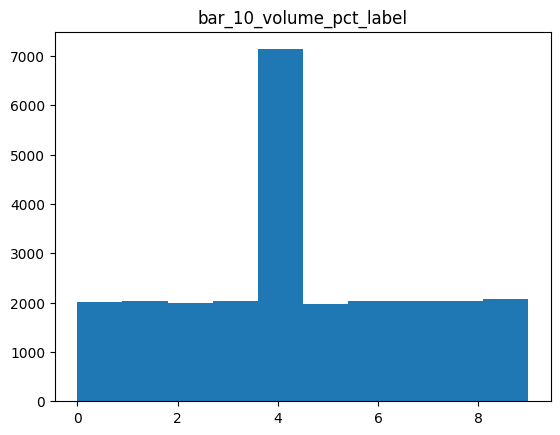

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


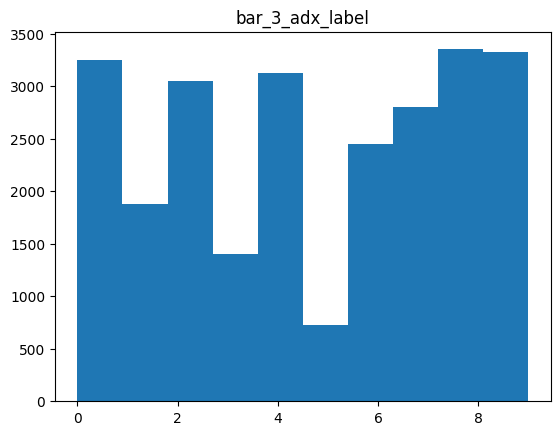

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


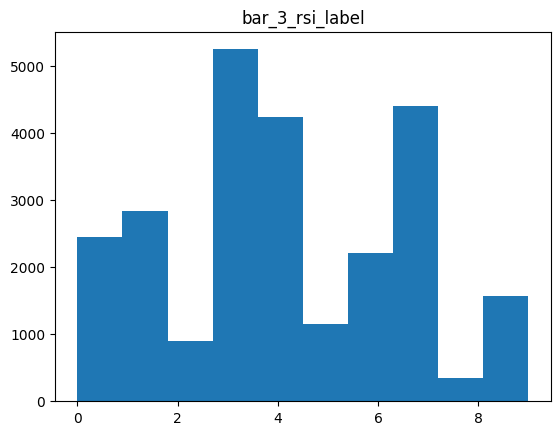

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


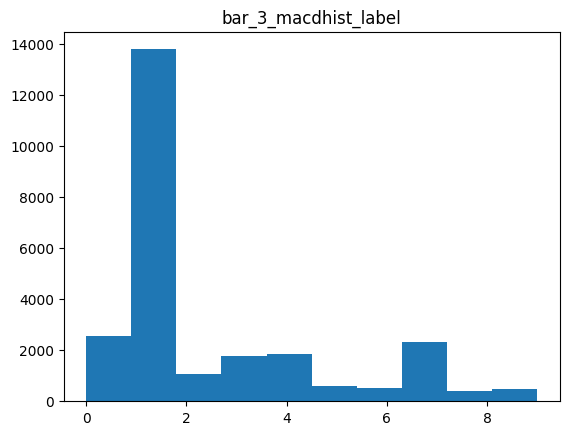

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


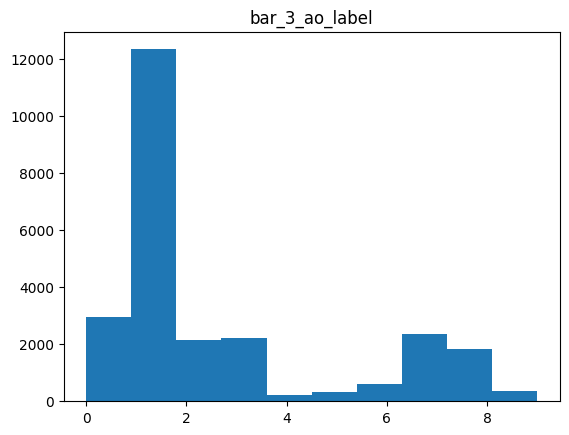

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


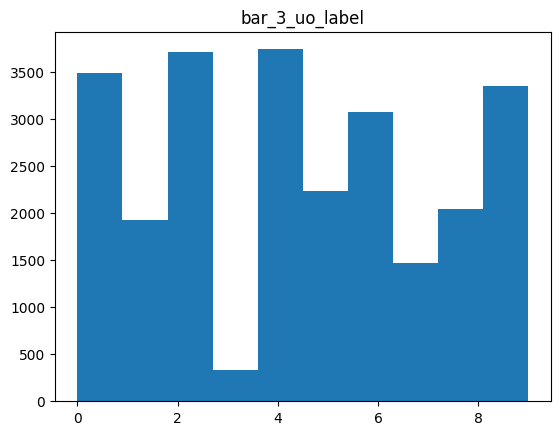

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


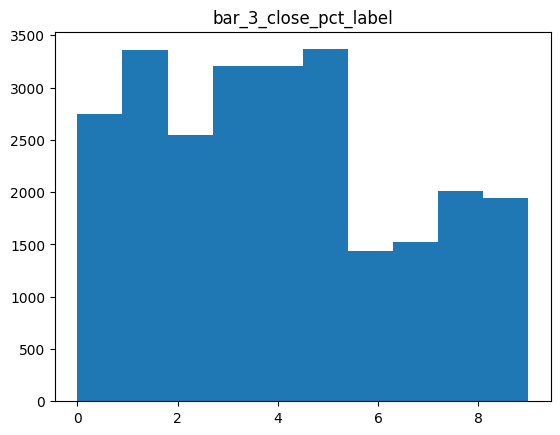

/tmp/ipykernel_80559/3392854626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_


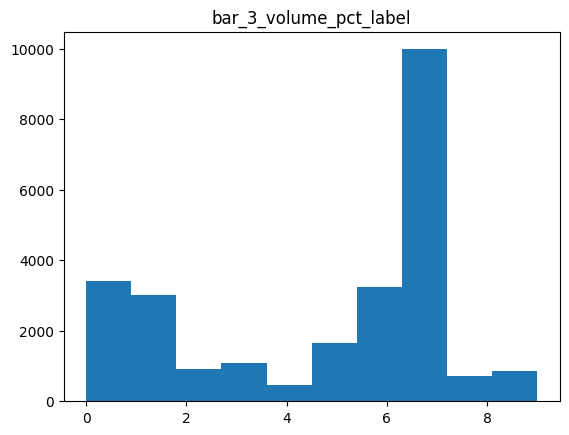

In [7]:
""" test DTW code  """
from tslearn.clustering import TimeSeriesKMeans
import random
k_means_label = []
# df_kmeans = numeric_df.dropna()
df_kmeans = numeric_df.fillna(0)
df_kmeans_ts = df_kmeans[100:]
df_kmeans_ts.reset_index(drop=True, inplace=True)
df_kmeans_ts.replace(np.inf, 0, inplace=True)
df_kmeans_ts.replace(-np.inf, 0, inplace=True)
for i,j in features_kemeans_dict.items():
    for k,v in j.items():
        k_name = f'{i}_{k}'
        k_clusters = 10
        kmeans = TimeSeriesKMeans(n_clusters=k_clusters, random_state=42)
        y_pred = kmeans.fit_predict(df_kmeans_ts[v])
        # kmeans.labels_
        # kmeans.cluster_centers_.shape
        df_kmeans_ts[f'{k_name}_label'] = kmeans.labels_
        k_means_label.append(f'{k_name}_label')
        plt.hist(kmeans.labels_, bins=10)
        plt.title(f'{k_name}_label')
        plt.show()

In [8]:
# for times in range(0,10):
#     for i in range(10):
#             color = "bgrcmyk"
            
#             # index_ = random.choice(df_kmeans_ts[df_kmeans_ts['bar_20_adx_label']==times].index)
#             index_ = random.choice(df_kmeans_ts[df_kmeans_ts['bar_20_ao_label']==times].index)
#             plt.xlabel(f'label_{times}_index_{index_}')
#         #     plt.title = f'label_{times}_index_{index_}'
#             # x = df_kmeans_ts.loc[index_,bar_3_ohlcv].columns
#             # y =  df_kmeans_ts.loc[index_,bar_3_ohlcv].values.reshape(3,1)
#             # plt.plot(x,y, color='blue', alpha=0.5, linewidth=1, linestyle='dashed', marker='o', markersize=4)
#             plt.plot(df_kmeans_ts.loc[index_,features_kmeans_dict_20bar['ao']], color=random.choice(color), alpha=0.5)

            
#     plt.show()        

In [9]:
# """ OHLCV """
# for times in range(0,20):
#     for i in range(3):
#             color = "bgrcmyk"
#             index_ = random.choice(df_kmeans[df_kmeans['bar_20_rsi_label']==times].index)
#             plt.xlabel(f'label_{times}_index_{index_}')
#             plt.plot(df_kmeans.loc[index_,features_kmeans_dict_20bar['rsi']], color=random.choice(color), alpha=0.5)
#     plt.show()        

In [10]:
# X = df_kmeans_ts[[b for i in features_kmeans_dict_1bar.values() for b in i ] + k_means_label]
# y = df_kmeans_ts[['close']]
# [b for i in features_kmeans_dict_1bar.values() for b in i ]
# list(features_kmeans_dict_1bar.values())
# df_kmeans_ts[k_means_label+list(features_kmeans_dict_1bar.keys())].plot(subplots=True, figsize=(20,20))
# features = list(df_kmeans.columns[-5:])
# features.append('position')
# features.extend(bar_1_volome_pct)
# df_kmeans[features].shape
# df_kmeans[[i for i in features]+['label']].tail(30)


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector,make_column_transformer
from sklearn.impute import SimpleImputer


In [16]:
df_kmeans_ts.to_json('df_kmeans_ts.json')

In [12]:
X = df_kmeans_ts[[b for i in features_kmeans_dict_1bar.values() for b in i ] + k_means_label]
y = df_kmeans_ts[['close']]
# X_pipeline = make_pipeline(StandardScaler())
# y_pipeline = make_pipeline(StandardScaler())
# X = X_pipeline.fit_transform(X)
# y = y_pipeline.fit_transform(y.values.reshape(-1, 1))
X.replace(np.inf, 0, inplace=True)
num_attribs = [b for i in features_kmeans_dict_1bar.values() for b in i ] 
cat_attribs = k_means_label
num_pipeline = make_pipeline(
    StandardScaler())
cat_pipeline = make_pipeline(
    OneHotEncoder())
# X_t = cat_pipeline.fit_transform(X[cat_attribs])
preprocessing = ColumnTransformer([
    ('num', num_pipeline ,num_attribs),
    # ('cat', cat_pipeline,make_column_selector(dtype_include=object))
    ('cat2', cat_pipeline,cat_attribs)])
# y_pipiline = make_pipeline(OneHotEncoder())
X_t = preprocessing.fit_transform(X).toarray()
y_t = y.values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t,test_size=0.2, random_state=42,shuffle=False)
# X_t = preprocessing.fit_transform(X_train).toarray()
# y_t = y_train.values.reshape(-1, 1)
# y_t = y_pipiline.fit_transform(y_train.values.reshape(-1, 1)).toarray()

/tmp/ipykernel_80559/721539942.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace(np.inf, 0, inplace=True)


In [13]:
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers

2022-10-25 17:08:50.077983: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-25 17:08:50.214223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-25 17:08:50.214245: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-25 17:08:50.245920: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-25 17:08:50.875781: W tensorflow/stream_executor/pla

In [14]:
# model =  Sequential(
#     [
# # Flatten(input_shape=(X_t.shape[1],)),
# Dense(320, activation='relu'),
# Dense(160, activation='relu'),
# Dense(64, activation='relu'),
# Dense(32, activation='relu'),
# Dense(3,activation='softmax')
#     ]
# )
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# ES = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

# model.fit(X_t, y_t, epochs=500, batch_size=32, validation_split=0.2, verbose=1, shuffle=False, callbacks=[ES], use_multiprocessing=True, workers=4)

In [73]:
model = Sequential()
model.add(Dense(320, input_dim=X_t.shape[1], activation='relu'))
model.add(Dense(160, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
model.fit(X_t, y_t, epochs=500, batch_size=32, validation_split=0.2, verbose=1, shuffle=False, use_multiprocessing=True, workers=4)


Epoch 1/500
634/634 [==============================] - 2s 2ms/step - loss: 77075.5312 - mse: 77075.5312 - mae: 176.8249 - val_loss: 1244952.6250 - val_mse: 1244952.6250 - val_mae: 1015.5157
Epoch 2/500
634/634 [==============================] - 1s 2ms/step - loss: 130578.1094 - mse: 130578.1094 - mae: 210.5721 - val_loss: 729944.3750 - val_mse: 729944.3750 - val_mae: 793.0022
Epoch 3/500
634/634 [==============================] - 1s 2ms/step - loss: 76190.8125 - mse: 76190.8125 - mae: 168.9101 - val_loss: 514060.2188 - val_mse: 514060.2188 - val_mae: 665.1754
Epoch 4/500
634/634 [==============================] - 1s 2ms/step - loss: 49359.7188 - mse: 49359.7188 - mae: 144.1469 - val_loss: 390922.7188 - val_mse: 390922.7188 - val_mae: 577.3875
Epoch 5/500
634/634 [==============================] - 1s 2ms/step - loss: 36617.0117 - mse: 36617.0117 - mae: 123.7408 - val_loss: 240766.9844 - val_mse: 240766.9844 - val_mae: 457.9738
Epoch 6/500
634/634 [==============================] - 1s 2m

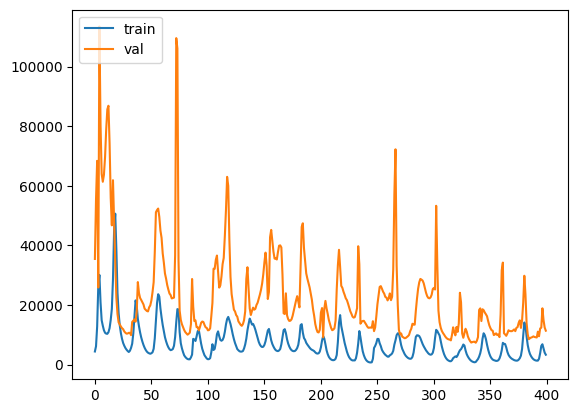

In [81]:
history = model.history.history
his = history['loss'][100:]
his_val = history['val_loss'][100:]
plt.plot(his)
plt.plot(his_val)
plt.legend(['train', 'val'], loc='upper left')
plt.show()